# Estimating $p(T)$ from APLAWD

- APLAWD database [@Lindsey1987]. British English.

- APLAWD GCI markings [@Serwy2017]. Very high-quality, hand-corrected.

- Time shift of WAV vs. EGG is ~ 0.95 msec [@Naylor2007]. **OK: Implemented.**

## Note about jitter

We model the 'true' pitch periods by a GP with $\sigma^2_n$ (i.e., `noise_sigma**2`) term which, when fitted, predicts unrealistically high voice jitter. This is because it has picked up all kinds of other effects in the data, working as a 'shock absorber' to keep the other GP parameters unharmed. We acknowledge this and during inference of the latent GP function replace this $\sigma_n^2$ noise term by zero. We still have inherent jitter in the process which we calculate below. It is likely that the jitter has been learned to some degree by the kernel because the `Matern32Kernel` is preferred over `Matern52Kernel` and `SqExponentialKernel`.

Note: we could circumvent this by using a Student-T process instead of a GP, which would absorp these shocks (i.e., outliers) for us, resulting in a more realistic $\sigma_n^2$ value which would relative more directly to jitter.

## Can we use `TIMIT-voiced`?

No.

The TIMIT-voiced database does not have GCI information; the frames nearly constant-length and give only voiced/unvoiced information.
In addition, I could not find a reference, and I think these values have been auto-generated and not manually verified.

In [1]:
%run init.ipy

from lib import aplawd
from lib import praat
from dgf import bijectors
from dgf import isokernels
from dgf import core
from dgf import constants
from dgf.prior import period

import dynesty
import pandas as pd
import warnings
import itertools
import scipy.stats
import multiprocessing

## Plot samples from APLAWD

The distribution of the unconstrained (i.e., transformed) $z = b^{-1}(T)$ variable is bimodal, pointing to the sex of the speakers.

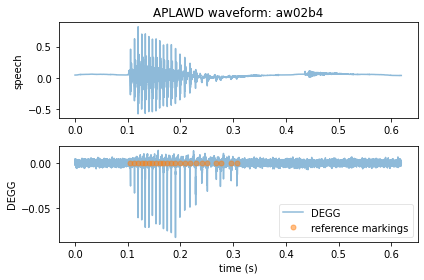

In [2]:
recordings = aplawd.APLAWD(__datadir__('APLAWDW/dataset'))
markings = aplawd.APLAWD_Markings(__datadir__('APLAWDW/markings/aplawd_gci'))

def plot_recording_and_degg(recordings, markings, key):
    """Adapted from https://github.com/serwy/aplawdw/blob/master/demo_001.py"""
    aplawd_db = recordings
    markings_db = markings

    key = np.random.choice(aplawd_db.keys())

    recording = aplawd_db.load_shifted(key)
    recording_gci = markings_db.load(recording.name)

    ax = plt.subplot(211)
    t = np.arange(len(recording.s)) / recording.fs
    plt.plot(t, recording.s, alpha=0.5)
    plt.ylabel('speech')
    plt.title('APLAWD waveform: %s' % recording.name)

    plt.subplot(212, sharex=ax)
    t = np.arange(len(recording.d)) / recording.fs

    plt.plot(t, recording.d, alpha=0.5, label='DEGG')

    plt.plot(t[recording_gci], 0*recording_gci, 'o', ms=5, alpha=0.5,
             label='reference markings')

    plt.legend(loc='lower right', fancybox=True, framealpha=0.5)
    plt.ylabel('DEGG')
    plt.xlabel('time (s)')

    plt.tight_layout()

plot_recording_and_degg(recordings, markings, recordings.random_key())

## Illustrate the data gathering process: `period.yield_training_pairs()`

We pair the manually checked markings with Praat's pulse estimates.
Each recording is split into groups of voiced markings and those groups are matched and aligned with Praat's pulse estimates.

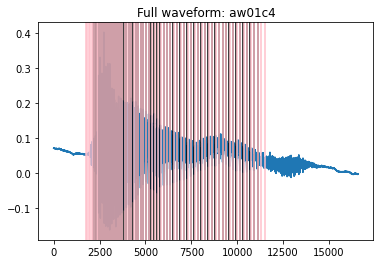

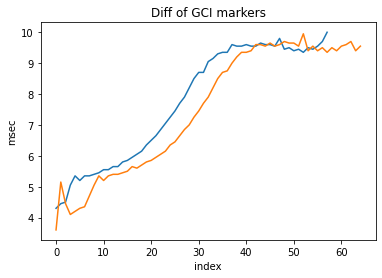

array([ 4.3 ,  4.45,  4.5 ,  5.05,  5.35,  5.2 ,  5.35,  5.35,  5.4 ,
        5.45,  5.55,  5.55,  5.65,  5.65,  5.8 ,  5.85,  5.95,  6.05,
        6.15,  6.35,  6.5 ,  6.65,  6.85,  7.05,  7.25,  7.45,  7.7 ,
        7.9 ,  8.2 ,  8.5 ,  8.7 ,  8.7 ,  9.05,  9.15,  9.3 ,  9.35,
        9.35,  9.6 ,  9.55,  9.55,  9.6 ,  9.55,  9.55,  9.65,  9.6 ,
        9.6 ,  9.55,  9.8 ,  9.45,  9.5 ,  9.4 ,  9.45,  9.35,  9.5 ,
        9.45,  9.55,  9.7 , 10.  ])

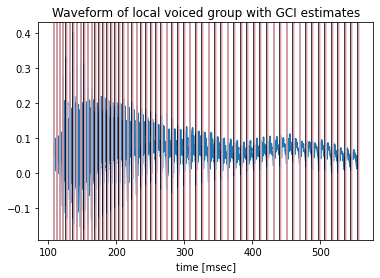

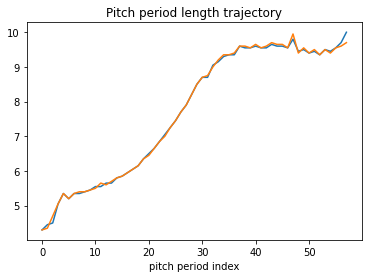

In [3]:
key = recordings.random_key()

k, m = period.load_recording_and_markers(recordings, markings, key)
pulses = praat.get_pulses(k.s, k.fs)
f = 1000/k.fs

title(f'Full waveform: {key}')
plot(k.s)
for p in m: axvline(p, color='black')
for p in pulses: axvline(p, color='pink')
#xlim(1800, 2300)
show()

figure()
title('Diff of GCI markers')
plot(diff(m)*f)
plot(diff(pulses)*f)
ylabel('msec')
xlabel('index')
show()

MIN_NUM_PERIODS = 3

voiced_groups = period.split_markings_into_voiced_groups(
    m, k.fs, constants.MAX_PERIOD_LENGTH_MSEC, MIN_NUM_PERIODS
)

for group in voiced_groups:
    if len(group) <= MIN_NUM_PERIODS + 1: continue

    group_periods = np.diff(group)*f # msec
    display(group_periods)
    
    group, group_praat = period.align_and_intersect(group, pulses)
    assert len(group) == len(group_praat)
    if len(group) <= MIN_NUM_PERIODS + 1:
        continue

    praat_periods = np.diff(group_praat) / k.fs * 1000 # msec
    if np.any(praat_periods > constants.MAX_PERIOD_LENGTH_MSEC):
        # Discard this and continue; we assume user will never accept
        # such Praat estimates so we don't want to model this case.
        warnings.warn(
            f'Discarded voiced group of GCIs because one of the synced '
            f'Praat periods is longer than {constants.MAX_PERIOD_LENGTH_MSEC} msec'
        )
        continue
    
    figure()
    title('Waveform of local voiced group with GCI estimates')
    t = np.arange(group[0], group[-1])
    plot(t*f, k.s[group[0] : group[-1]])
    for p in group: axvline(p*f, color='black')
    for p in group_praat: axvline(p*f, color='pink')
    xlabel('time [msec]')
    
    show()
    
    figure()
    title('Pitch period length trajectory')
    plot(np.diff(group) * f)
    plot(np.diff(group_praat) * f)
    xlabel('pitch period index')
    show()

## Plot marginal statistics

In [4]:
training_pairs, training_pairs_z = period.get_aplawd_training_pairs()

# Check if everything is within the bijector bounds
assert not np.any(np.concatenate([np.isnan(x) | np.isnan(y) for x, y in training_pairs_z]))

def plot_marginal(training_pairs, lab):
    true_marginal = []
    praat_marginal = []

    for true_group, praat_group in training_pairs:
        true_marginal.append(true_group)
        praat_marginal.append(praat_group)

    true_marginal = np.concatenate(true_marginal)
    praat_marginal = np.concatenate(praat_marginal)

    hist([true_marginal, praat_marginal], bins=50)
    xlabel(lab)
    
    return true_marginal, praat_marginal

[Memory]62.4s, 1.0min   : Loading get_aplawd_training_pairs...


,0
count,13960.00000
mean,38.54384
std,25.78087
min,4.00000
25%,19.00000
50%,37.00000
75%,53.00000
max,314.00000


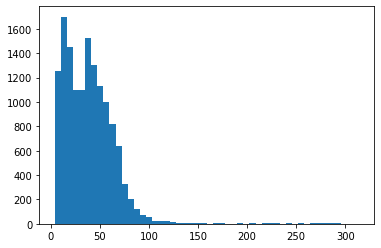

In [5]:
len_data_points = np.array([len(pair[0]) for pair in training_pairs])
hist(len_data_points, bins=50)
pd.DataFrame(len_data_points).describe()

,true,Praat
count,538072.000000,538072.000000
mean,7.141060,7.120279
std,2.192912,2.161199
min,2.000000,2.000000
25%,5.400000,5.400000
50%,6.900000,6.900000
75%,8.500000,8.500000
max,20.000000,20.000000


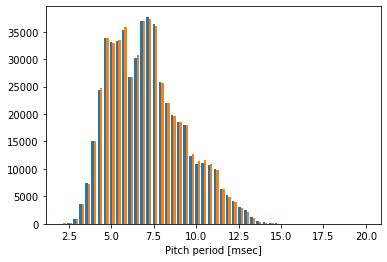

In [11]:
true_marginal, praat_marginal = plot_marginal(training_pairs, 'Pitch period [msec]')
pd.DataFrame({'true': true_marginal, 'Praat': praat_marginal}).describe()

,true,Praat
count,538072.000000,538072.000000
mean,1.919356,1.917151
std,0.306189,0.304299
min,0.621563,0.621563
25%,1.686399,1.686399
50%,1.931521,1.931521
75%,2.140066,2.140066
max,3.000332,3.000332


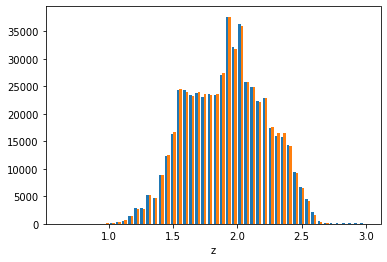

In [12]:
true_marginal_z, praat_marginal_z = plot_marginal(training_pairs_z, 'z')
pd.DataFrame({'true': true_marginal_z, 'Praat': praat_marginal_z}).describe()

## Fit GP model

The GP model for the true GCI markings is independent of the Praat observation model, so we train them separately.

The observation noise $\sigma_n^2$ (`noise_sigma**2`) relates to voice jitter.

The `Matern32Kernel` has the highest posterior probability. The fitted source envelope lengthscales $\lambda$ differ quite strongly between the kernels, with highest evidence for $\lambda \approx 10$.

The `Matern12Kernel` did converge but has a very long lengthscale, but low evidence. **So there is a preference for some roughness, but not too much: this indicates the learning of a jitter component.**

The Praat observation error is fitted below.

In [8]:
# The nested sampling inference for these kernels takes around 5 +/- 0.5 hrs
for kernel_name in ('Matern12Kernel', 'Matern32Kernel', 'Matern52Kernel', 'SqExponentialKernel'):
    results = period.model_true_pitch_periods(kernel_name, 32)
    print(kernel_name)
    print(results.summary())
    print('Information (bans):', results.information[-1] * log10(e))

[Memory]7.2s, 0.1min    : Loading model_true_pitch_periods...
Matern12Kernel
Summary
nlive: 100
niter: 5425
ncall: 203043
eff(%):  2.721
logz: 260040.522 +/-  0.791
None
Information (bans): 20.67241219201684
[Memory]7.2s, 0.1min    : Loading model_true_pitch_periods...
Matern32Kernel
Summary
nlive: 100
niter: 3274
ncall: 111582
eff(%):  3.024
logz: 277300.589 +/-  0.622
None
Information (bans): 12.412335137662506
[Memory]7.2s, 0.1min    : Loading model_true_pitch_periods...
Matern52Kernel
Summary
nlive: 100
niter: 3400
ncall: 116406
eff(%):  3.007
logz: 276704.626 +/-  0.633
None
Information (bans): 12.863285196883021
[Memory]7.2s, 0.1min    : Loading model_true_pitch_periods...
SqExponentialKernel
Summary
nlive: 100
niter: 3357
ncall: 114532
eff(%):  3.018
logz: 270231.759 +/-  0.629
None
Information (bans): 12.672004244218222


[Memory]7.3s, 0.1min    : Loading model_true_pitch_periods...


'Matern12Kernel'

Summary
nlive: 100
niter: 5425
ncall: 203043
eff(%):  2.721
logz: 260040.522 +/-  0.791


None

'Information (bans)'

20.67241219201684

Quantiles:
mean [(0.025, 1.9668605496865514), (0.5, 1.9676789323722692), (0.975, 1.9687712622379434)]
Quantiles:
sigma [(0.025, 0.8729488797478909), (0.5, 0.9437589021022017), (0.975, 0.998208750120745)]
Quantiles:
scale [(0.025, 194.69232536107086), (0.5, 228.0102226615649), (0.975, 255.67960597000686)]
Quantiles:
noise_sigma [(0.025, 0.11210563228481712), (0.5, 0.11234425879597781), (0.975, 0.11256313321187877)]


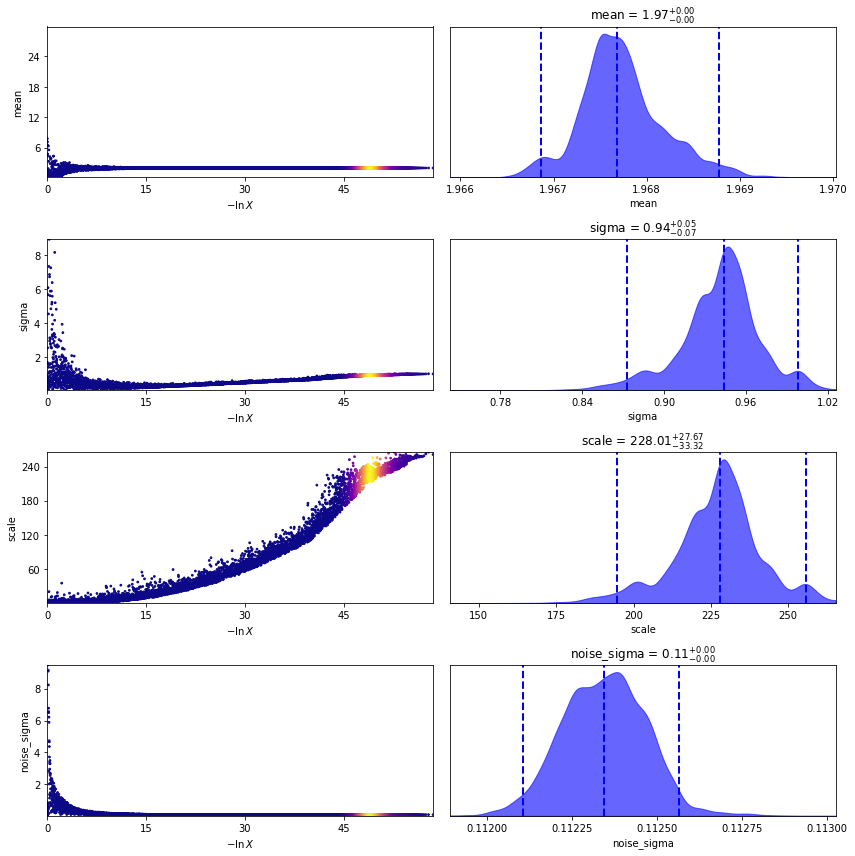

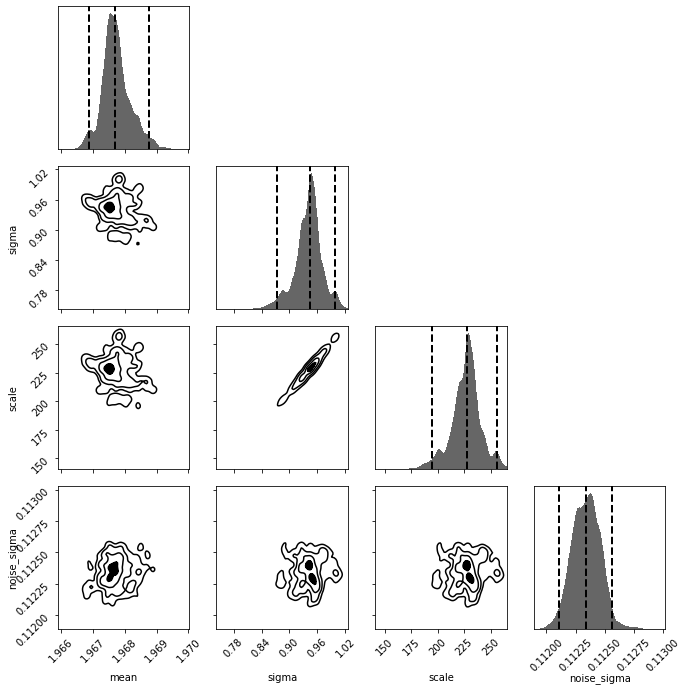

[Memory]11.6s, 0.2min   : Loading model_true_pitch_periods...


'Matern32Kernel'

Summary
nlive: 100
niter: 3274
ncall: 111582
eff(%):  3.024
logz: 277300.589 +/-  0.622


None

'Information (bans)'

12.412335137662506

Quantiles:
mean [(0.025, 1.966994385999475), (0.5, 1.9678669885957922), (0.975, 1.9687518896462353)]
Quantiles:
sigma [(0.025, 0.34210485787260436), (0.5, 0.3450764079757091), (0.975, 0.3484369777254027)]
Quantiles:
scale [(0.025, 10.69436242864968), (0.5, 10.784772577368843), (0.975, 10.880290568534285)]
Quantiles:
noise_sigma [(0.025, 0.11192857685441861), (0.5, 0.11218482122832833), (0.975, 0.11241556558333252)]


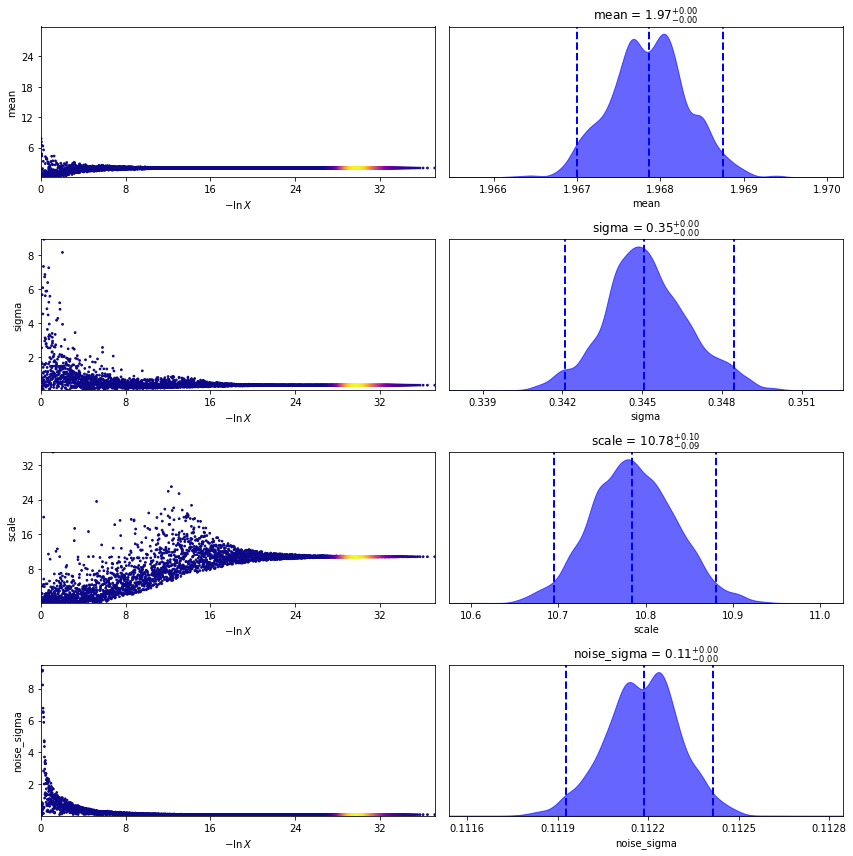

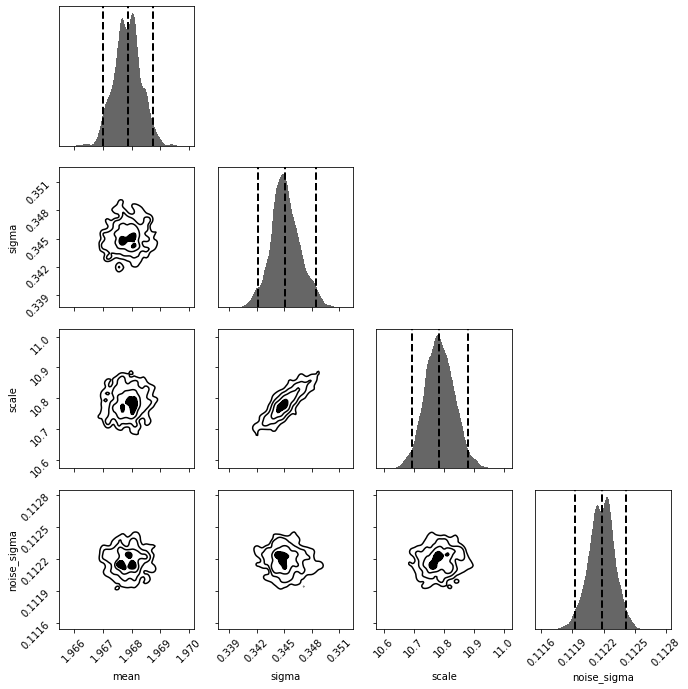

[Memory]15.8s, 0.3min   : Loading model_true_pitch_periods...


'Matern52Kernel'

Summary
nlive: 100
niter: 3400
ncall: 116406
eff(%):  3.007
logz: 276704.626 +/-  0.633


None

'Information (bans)'

12.863285196883021

Quantiles:
mean [(0.025, 1.9658333201203142), (0.5, 1.9668214678868425), (0.975, 1.9677426648085117)]
Quantiles:
sigma [(0.025, 0.3151593437825655), (0.5, 0.3175001628059104), (0.975, 0.3199210646541626)]
Quantiles:
scale [(0.025, 7.897924880111011), (0.5, 7.949574039835972), (0.975, 8.006500674205215)]
Quantiles:
noise_sigma [(0.025, 0.1126980281693643), (0.5, 0.11292768425084927), (0.975, 0.11317573446572546)]


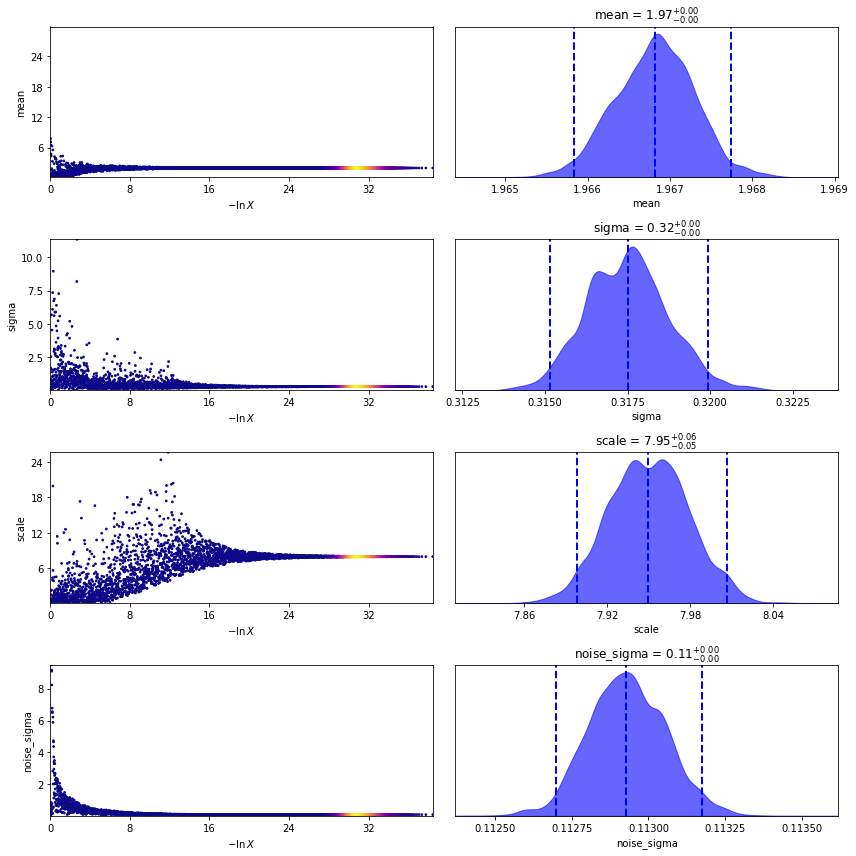

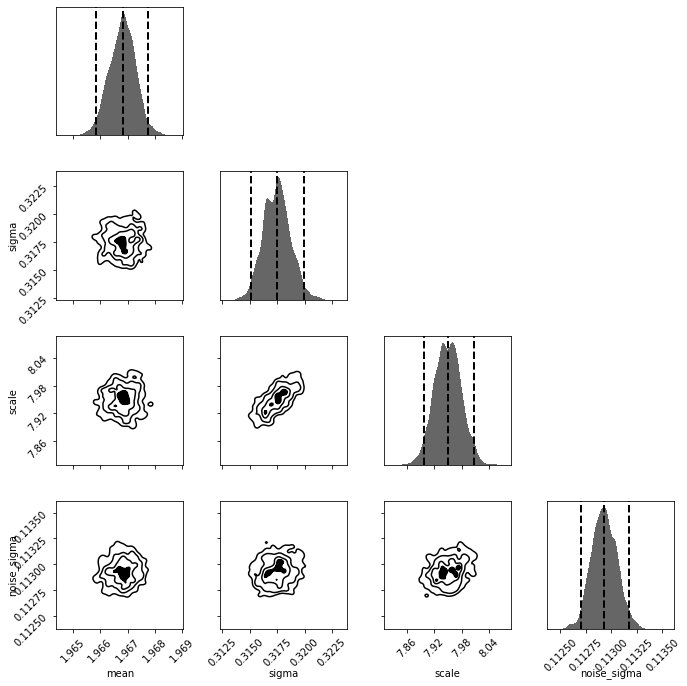

[Memory]19.9s, 0.3min   : Loading model_true_pitch_periods...


'SqExponentialKernel'

Summary
nlive: 100
niter: 3357
ncall: 114532
eff(%):  3.018
logz: 270231.759 +/-  0.629


None

'Information (bans)'

12.672004244218222

Quantiles:
mean [(0.025, 1.9636783580300021), (0.5, 1.9646062878494541), (0.975, 1.9655920027734128)]
Quantiles:
sigma [(0.025, 0.2858444399090665), (0.5, 0.2875571921822095), (0.975, 0.28914953648206493)]
Quantiles:
scale [(0.025, 5.355206957232395), (0.5, 5.380010968868277), (0.975, 5.404154984328088)]
Quantiles:
noise_sigma [(0.025, 0.11488123188116203), (0.5, 0.11511436397034945), (0.975, 0.11536749851122961)]


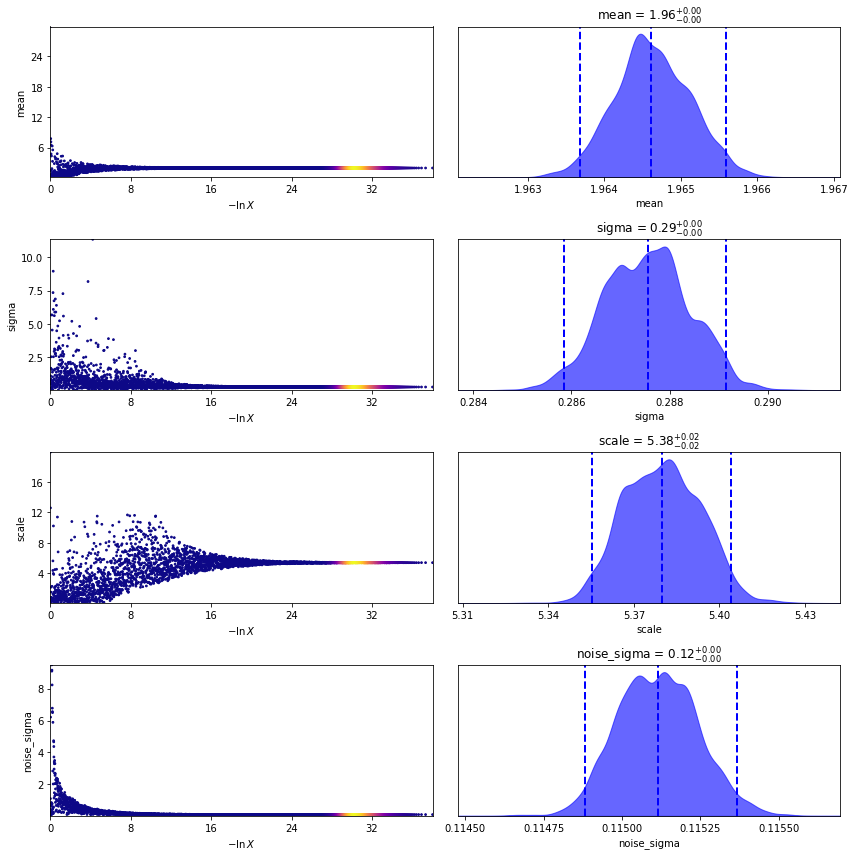

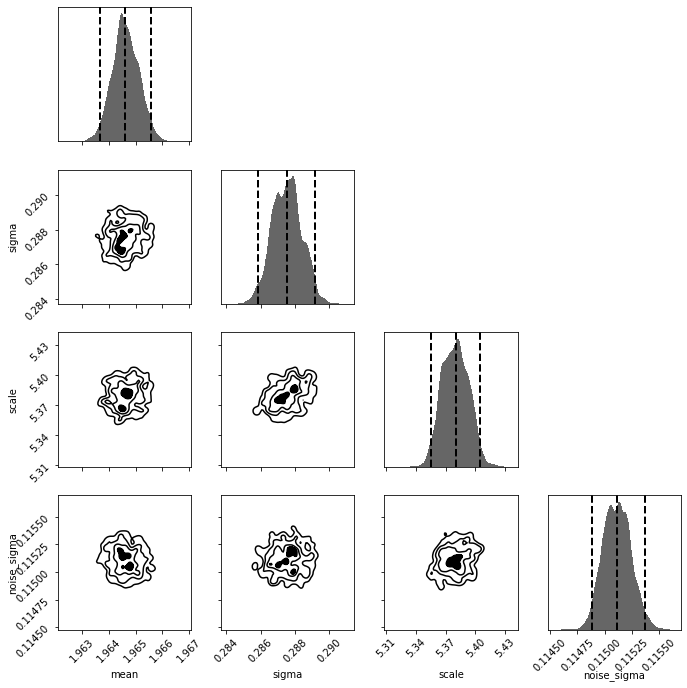

In [9]:
from dynesty import plotting

def plot_kernel_results(kernel_name, kernel_M = 32):
    results = period.model_true_pitch_periods(kernel_name, kernel_M)

    display(kernel_name)
    display(results.summary())
    display('Information (bans)', results.information[-1] * log10(e))
    
    VARIABLE_NAMES = ['mean', 'sigma', 'scale', 'noise_sigma']
    fig, axes = dynesty.plotting.traceplot(
        results, show_titles=True,
        labels=VARIABLE_NAMES,
        verbose=True
    )
    tight_layout()

    fg, ax = dynesty.plotting.cornerplot(results, labels=VARIABLE_NAMES)
    tight_layout()
    show()

plot_kernel_results('Matern12Kernel')
plot_kernel_results('Matern32Kernel')
plot_kernel_results('Matern52Kernel')
plot_kernel_results('SqExponentialKernel')

## Fit Praat observation error

We model `p(T_praat | T_true) = N(T_true, praat_sigma² * I)`. `praat_sigma` is 0.05 or about half of `noise_sigma` above, so quite substantial correction.

[Memory]24.1s, 0.4min   : Loading model_praat_pitch_periods...
Summary
nlive: 100
niter: 1333
ncall: 23915
eff(%):  5.992
logz: 850647.110 +/-  0.381


None

'Information (bans)'

4.582147846748053

Quantiles:
praat_sigma [(0.025, 0.04970567556164484), (0.5, 0.04979464170179949), (0.975, 0.04988655776548356)]


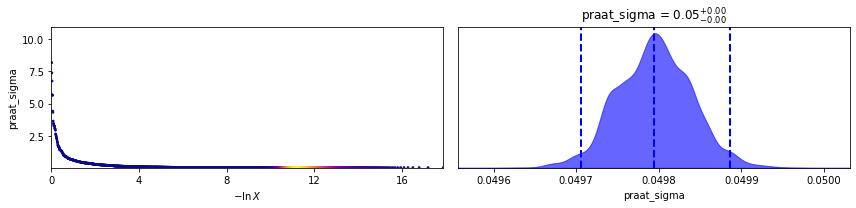

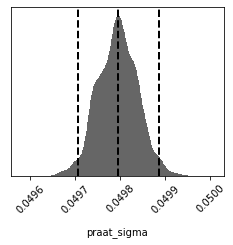

In [10]:
# Takes 30 minutes
results = period.model_praat_pitch_periods()

display(results.summary())
display('Information (bans)', results.information[-1] * log10(e))

VARIABLE_NAMES = ['praat_sigma']
fig, axes = dynesty.plotting.traceplot(
    results, show_titles=True,
    labels=VARIABLE_NAMES,
    verbose=True
)
tight_layout()

fg, ax = dynesty.plotting.cornerplot(results, labels=VARIABLE_NAMES)
tight_layout()
show()

## Check the fit

In [11]:
period.fit_aplawd_z()

[Memory]25.2s, 0.4min   : Loading model_true_pitch_periods...
[Memory]25.2s, 0.4min   : Loading model_praat_pitch_periods...


{'mean': 1.967859870873125,
 'sigma': 0.3451663118178634,
 'scale': 10.785536290489597,
 'noise_sigma': 0.1121804770163076,
 'praat_sigma': array(0.04979445)}

[Memory]25.3s, 0.4min   : Loading model_true_pitch_periods...
[Memory]25.3s, 0.4min   : Loading model_praat_pitch_periods...


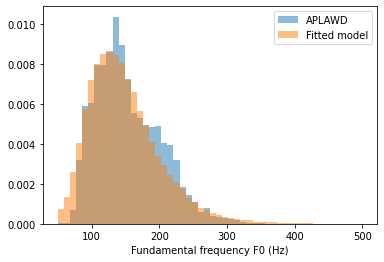

In [12]:
period_prior = period.marginal_prior()

samples = period_prior.sample(int(1e5), seed=jax.random.PRNGKey(50))

hist(1000/true_marginal, bins=50, alpha=.5, density=True, label='APLAWD');
hist(1000/np.asarray(samples), bins=50, alpha=.5, density=True, label='Fitted model');
legend()
xlabel('Fundamental frequency F0 (Hz)');

[Memory]1149.2s, 19.2min: Loading model_true_pitch_periods...
[Memory]1149.2s, 19.2min: Loading model_praat_pitch_periods...


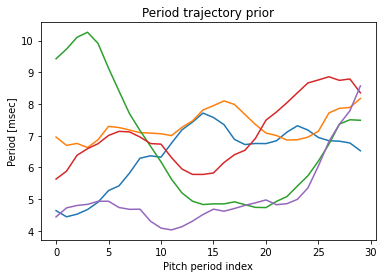

In [19]:
P = 30

prior = period.trajectory_prior(P)
samples = prior.sample(5, seed=jax.random.PRNGKey(randint(0,1000)))
plot(samples.T)
xlabel('Pitch period index');
ylabel('Period [msec]');
title('Period trajectory prior');

[Memory]28.7s, 0.5min   : Loading model_true_pitch_periods...
[Memory]28.7s, 0.5min   : Loading model_praat_pitch_periods...


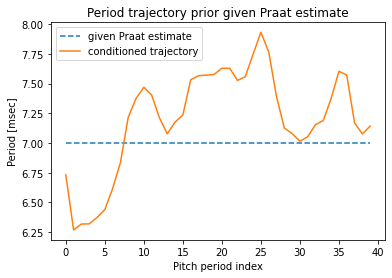

In [14]:
praat_estimate = [7.]*40

prior = period.trajectory_prior(praat_estimate=praat_estimate)
samples = prior.sample(1, seed=jax.random.PRNGKey(randint(0,1000)))
plot(praat_estimate, '--', label="given Praat estimate")
plot(samples.T, label="conditioned trajectory")
legend()
xlabel('Pitch period index');
ylabel('Period [msec]');
title('Period trajectory prior given Praat estimate');

### Measure jitter

The jitter implied by the prior is reasonably realistic. We use Praat's `jitter (local, absolute)` from <https://www.fon.hum.uva.nl/praat/manual/Voice_2__Jitter.html> because it is less sensitive to what we choose as a consistent group of pitch periods.

[Memory]31.1s, 0.5min   : Loading model_true_pitch_periods...
[Memory]31.1s, 0.5min   : Loading model_praat_pitch_periods...
[Memory]31.1s, 0.5min   : Loading model_true_pitch_periods...
[Memory]31.1s, 0.5min   : Loading model_praat_pitch_periods...


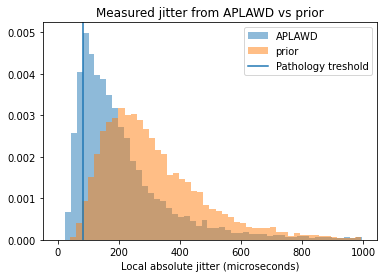

In [15]:
MAX_JITTER_USEC = 1000
NUM_SAMPLES = int(1e4)
NUMBINS = 50

# Measure APLAWD jitter over voiced groups
def measure_jitter(x):
    # https://www.fon.hum.uva.nl/praat/manual/PointProcess__Get_jitter__local__absolute____.html
    return float(np.mean(np.abs(np.diff(x))))

aplawd_jitter = np.array([measure_jitter(true_period) for (true_period, _) in training_pairs])
aplawd_jitter_usec = aplawd_jitter*1000
aplawd_jitter_usec = aplawd_jitter_usec[aplawd_jitter_usec < MAX_JITTER_USEC]

# Measure jitter from GP prior over one lengthscale
fit_z = period.fit_aplawd_z()
P = int(fit_z['scale']) # Measure over one lengthscale (has little influence)

prior = period.trajectory_prior(P)
samples = prior.sample(NUM_SAMPLES, seed=jax.random.PRNGKey(48702))

prior_jitter = np.mean(np.abs(np.diff(samples,axis=1)),axis=1)
prior_jitter_usec = prior_jitter*1000
prior_jitter_usec = prior_jitter_usec[prior_jitter_usec < MAX_JITTER_USEC]

# Plot
hist(aplawd_jitter_usec, bins=NUMBINS, alpha=0.5, density=True, label='APLAWD');
hist(prior_jitter_usec, bins=NUMBINS, alpha=0.5, density=True, label='prior');
axvline(83.200, label='Pathology treshold')
legend()
title('Measured jitter from APLAWD vs prior')
xlabel('Local absolute jitter (microseconds)');